# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
from typing import List

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.regression.linear_model import OLS
from statsmodels.regression.quantile_regression import QuantReg

from sklearn.metrics import (make_scorer, 
                             r2_score, 
                             mean_absolute_error,
                             mean_squared_error, 
                             mean_absolute_percentage_error)

import geopandas as gpd

# Data loading

In [2]:
data = pd.read_csv("diamonds.csv")
data_coords = pd.read_csv("coords_diamonds.csv")

# Data preprocessing

## diamonds

Quick view of data:

In [3]:
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Check shape and data types:

In [4]:
print(data.shape)
data.dtypes

(53930, 11)


Unnamed: 0      int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
price           int64
x             float64
y             float64
z             float64
dtype: object

Check if first column ("Unnamed: 0") is equal to index

In [5]:
data_first_col = data["Unnamed: 0"]
data_index = data.index.to_series()

np.allclose(data_first_col, data_index)

True

## coords diamonds

Quick view of data:

In [6]:
data_coords.head()

,Unnamed: 0,latitude,longitude
0,0,39.8813889,-83.093056
1,1,33.4150000,-111.548889
2,2,40.1672222,-105.101389
3,3,37.3711111,-85.583056
4,4,48.5394444,-121.745000


Check shape and data types:

In [7]:
print(data_coords.shape)
data_coords.dtypes # It is an error that "latitude" is an object

(53930, 3)


Unnamed: 0      int64
latitude       object
longitude     float64
dtype: object

Check if first column ("Unnamed: 0") is equal to index

In [8]:
data_coords_first_col = data_coords["Unnamed: 0"]
data_coords_index = data_coords.index.to_series()

np.allclose(data_coords_first_col, data_coords_index)

True

## Delete unnecesary data

In [9]:
data = data.drop(["Unnamed: 0"], axis=1)
data_coords = data_coords.drop(["Unnamed: 0"], axis=1)

## Merge dataframes

In [10]:
df = pd.merge(data, data_coords, left_index=True, right_index=True)

In [11]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,latitude,longitude
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,39.8813889,-83.093056
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,33.4150000,-111.548889
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,40.1672222,-105.101389
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,37.3711111,-85.583056
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,48.5394444,-121.745000


## Fix "latitud" column type

In [12]:
df['latitude'] = df['latitude'].astype(float) # error with '33q.200088' value

ValueError: could not convert string to float: '33q.200088'

Drop row with error:

In [13]:
df = df.drop(df[df['latitude'] == '33q.200088'].index)

Cast column:

In [14]:
df['latitude'] = df['latitude'].astype(float)

In [15]:
df.dtypes # Done!

carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
price           int64
x             float64
y             float64
z             float64
latitude      float64
longitude     float64
dtype: object

# Exploratory Data Analysis

In [16]:
def _numerical_eda(df: pd.DataFrame,
                   features: List[str]
                  ) -> pd.DataFrame:
    """
    Exploratory data analysis of numerical features
    """
    df = df[features]

    len_list = []
    null_list = []
    prop_null_list = []
    mean_list = []
    std_list = []
    min_list = []
    per_1_list = []
    per_25_list = []
    median_list = []
    per_75_list = []
    per_99_list = []
    max_list = []

    for i in features:
        len_v = len(df)
        len_list.append(len_v)
        null_v = df[i].isnull().sum()
        null_list.append(null_v)
        prop_null_v = null_v/len_v
        prop_null_list.append(prop_null_v)
        mean_v = np.mean(df[i])
        mean_list.append(mean_v)
        std_v = np.std(df[i])
        std_list.append(std_v)
        min_v = np.min(df[i])
        min_list.append(min_v)
        per_1_v = np.percentile(df[i].dropna(), 1)
        per_1_list.append(per_1_v)
        per_25_v = np.percentile(df[i].dropna(), 25)
        per_25_list.append(per_25_v)
        median_v = np.median(df[i].dropna())
        median_list.append(median_v)
        per_75_v = np.percentile(df[i].dropna(), 75)
        per_75_list.append(per_75_v)
        per_99_v = np.percentile(df[i].dropna(), 99)
        per_99_list.append(per_99_v)
        max_v = np.max(df[i])
        max_list.append(max_v)

    df = pd.DataFrame({"feature": features,
                       "n_row": len_list,
                       "n_col": len(features),
                       "num_null": null_list,
                       "prop_null": prop_null_list,
                       "mean": mean_list,
                       "std": std_list,
                       "min": min_list,
                       "per_1": per_1_list,
                       "per_25": per_25_list,
                       "median": median_list,
                       "per_75": per_75_list,
                       "per_99": per_99_list,
                       "max": max_list
                      })    
    df  = df.sort_values(by=["feature"])
    df = df.reset_index(drop=True)
    return df


def _categorical_eda(df: pd.DataFrame,
                     features: List[str]
                    ) -> pd.DataFrame:
    """
    Exploratory data analysis of categorical features
    """
    df = df[features]

    len_list = []
    null_list = []
    prop_null_list = []
    category_list = []
    num_category_list = []
    mode_list = []
    mode_count_list = []

    for i in features:
        len_v = len(df)
        len_list.append(len_v)
        null_v = df[i].isnull().sum()
        null_list.append(null_v)
        prop_null_v = null_v/len_v
        prop_null_list.append(prop_null_v)
        category_v = df[i].unique()
        category_list.append(category_v)
        num_category_v = len(category_v)
        num_category_list.append(num_category_v)
        mode_v = df[i].mode()[0]
        mode_list.append(mode_v)
        mode_count_v = len(df[i][df[i] == mode_v])
        mode_count_list.append(mode_count_v)

    df = pd.DataFrame({"feature": features,
                       "n_row": len_list,
                       "n_col": len(features),
                       "num_null": null_list,
                       "prop_null": prop_null_list,
                       "num_categories": num_category_list,
                       "category": category_list,
                       "mode": mode_list,
                       "mode_count": mode_count_list,
                      })
    df  = df.sort_values(by=["feature"])
    df = df.reset_index(drop=True)
    return df

## Numerical and Categorical Features

In [17]:
numerical_features = list([col for col in df.select_dtypes(['float64', 'int64']).columns])
categorical_features = list([col for col in df.select_dtypes('object').columns])

In [18]:
numerical_features # longitude has an error in its name

['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'latitude', 'longitude ']

In [19]:
# fix longitude column name 
df = df.rename(columns={'longitude ': 'longitude'})

In [20]:
numerical_features = list([col for col in df.select_dtypes(['float64', 'int64']).columns])
categorical_features = list([col for col in df.select_dtypes('object').columns])

In [21]:
numerical_features # Done!

['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'latitude', 'longitude']

In [22]:
categorical_features

['cut', 'color', 'clarity']

## Descriptive statistics

In [23]:
_numerical_eda(df, numerical_features)

,feature,n_row,n_col,num_null,prop_null,mean,std,min,per_1,per_25,median,per_75,per_99,max
0,carat,53929,9,0,0.000000,0.797978,0.474035,0.200000,0.240000,0.400000,0.700000,1.040000,2.180000,5.010000
1,depth,53929,9,2962,0.054924,61.749369,1.432893,43.000000,57.900000,61.000000,61.800000,62.500000,65.600000,79.000000
2,latitude,53929,9,0,0.000000,38.137444,10.485164,-82.862752,-25.828765,34.147778,39.457778,42.800556,55.603661,72.700000
3,longitude,53929,9,0,0.000000,-86.693441,39.773049,-173.985008,-126.650000,-112.073333,-87.889167,-78.680278,120.271751,178.017649
4,price,53929,9,0,0.000000,3933.091769,3989.619402,326.000000,429.000000,950.000000,2401.000000,5325.000000,17378.440000,18823.000000
5,table,53929,9,0,0.000000,57.457336,2.234577,43.000000,53.000000,56.000000,57.000000,59.000000,64.000000,95.000000
6,x,53929,9,1090,0.020212,5.730620,1.127572,-6.370000,4.013800,4.710000,5.700000,6.540000,8.360000,10.740000
7,y,53929,9,585,0.010848,5.733115,1.141865,-6.610000,4.040000,4.720000,5.710000,6.540000,8.340000,58.900000
8,z,53929,9,0,0.000000,3.538139,0.708909,-4.060000,2.480000,2.910000,3.530000,4.040000,5.150000,31.800000


In [24]:
_categorical_eda(df, categorical_features)

,feature,n_row,n_col,num_null,prop_null,num_categories,category,mode,mode_count
0,clarity,53929,3,0,0.0,30,"[SI2, SI1, VS1, VS2, VVS2, VVS1, I1, IF, S?I1,...",SI1,13058
1,color,53929,3,0,0.0,26,"[E, I, J, H, F, G, D, *'E, #F, &G, !H, ?J, #D,...",G,11284
2,cut,53929,3,0,0.0,26,"[Ideal, Premium, Good, Very Good, Fair, Very G...",Ideal,21537


## Fix Categorical features values

Take a quick look:

In [25]:
df['clarity'].value_counts()

clarity
SI1       13058
VS2       12249
SI2        9188
VS1        8164
VVS2       5062
VVS1       3653
IF         1790
I1          741
VS?1          2
&VS2          2
VV?S1         1
S&I1          1
*'SI1         1
V#S2          1
SI?1          1
VV#S1         1
VVS*'2        1
#SI!1         1
*'SI2         1
#VS1          1
VS#2          1
!VS2          1
V!S2          1
V&S2          1
S*'I2         1
S*'I1         1
&SI2          1
SI!1          1
S?I1          1
S!I2          1
Name: count, dtype: int64

In [26]:
df['color'].value_counts()

color
G      11284
E       9789
F       9535
H       8301
D       6773
I       5417
J       2805
*'E        3
?J         2
!E         2
&G         2
#F         2
!F         1
*'I        1
?E         1
#G         1
&F         1
*'F        1
&I         1
?H         1
#H         1
?G         1
!I         1
#D         1
!H         1
&E         1
Name: count, dtype: int64

In [27]:
df['cut'].value_counts()

cut
Ideal          21537
Premium        13782
Very Good      12076
Good            4900
Fair            1609
P?remium           2
*'Ideal            2
Go?od              2
Ide&al             2
Id!eal             1
&Ideal             1
V&ery Good         1
Ide*'al            1
Very *'Good        1
G#ood              1
&Premium           1
Pr?emium           1
Ide!al             1
Very Go#od         1
Pre!mium           1
!Good              1
#Very Good         1
I#deal             1
P*'remium          1
Very Goo!d         1
Very G#ood         1
Name: count, dtype: int64

The problem is special characters in those strings. Let's fix it:

In [28]:
df['clarity'] = df['clarity'].str.replace('[^a-zA-Z0-9]', '', regex=True)
df['color'] = df['color'].str.replace('[^a-zA-Z0-9]', '', regex=True)
df['cut'] = df['cut'].str.replace('[^a-zA-Z0-9]', '', regex=True)

In [29]:
_categorical_eda(df, categorical_features) # awesome!

,feature,n_row,n_col,num_null,prop_null,num_categories,category,mode,mode_count
0,clarity,53929,3,0,0.0,8,"[SI2, SI1, VS1, VS2, VVS2, VVS1, I1, IF]",SI1,13065
1,color,53929,3,0,0.0,7,"[E, I, J, H, F, G, D]",G,11288
2,cut,53929,3,0,0.0,5,"[Ideal, Premium, Good, VeryGood, Fair]",Ideal,21546


In [30]:
df['clarity'].value_counts()

clarity
SI1     13065
VS2     12256
SI2      9192
VS1      8167
VVS2     5063
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64

In [31]:
df['color'].value_counts()

color
G    11288
E     9796
F     9540
H     8304
D     6774
I     5420
J     2807
Name: count, dtype: int64

In [32]:
df['cut'].value_counts()

cut
Ideal       21546
Premium     13788
VeryGood    12082
Good         4904
Fair         1609
Name: count, dtype: int64

## Histograms and Boxplots

In [33]:
def _plt_histogram(df: pd.DataFrame,
                   features: List[str]
                  ):
    """
    Plot a histogram for every numerical column in features argument
    """
    df[features].hist(figsize=(10, 8))
    plt.tight_layout()
    plt.show()
    
def _plt_boxplot(df: pd.DataFrame,
                 features: List[str]
                ):
    """
    Plot a boxplot for every numerical column in features argument
    """
    k = _plt_boxplot_grid(features)
    plt.figure(figsize=(10, k*10))
    
    props_dict = {'linewidth': 2,
                  'color': '#2773B2'
                 }
    
    for n, ticker in enumerate(features):
        ax = plt.subplot(k*3, 3, n + 1)

        df[[ticker]].boxplot(boxprops=props_dict,
                             medianprops=props_dict,
                             whiskerprops=props_dict,
                             capprops=props_dict
                            )
    plt.tight_layout()
    plt.show()

def _plt_boxplot_grid(features):    
    return math.ceil(len(features)/3)

Histogram:

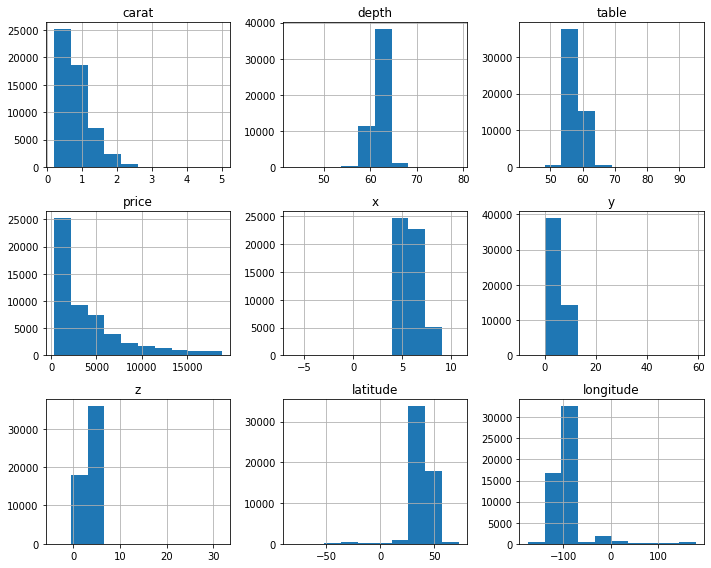

In [34]:
_plt_histogram(df, numerical_features)

Boxplot:

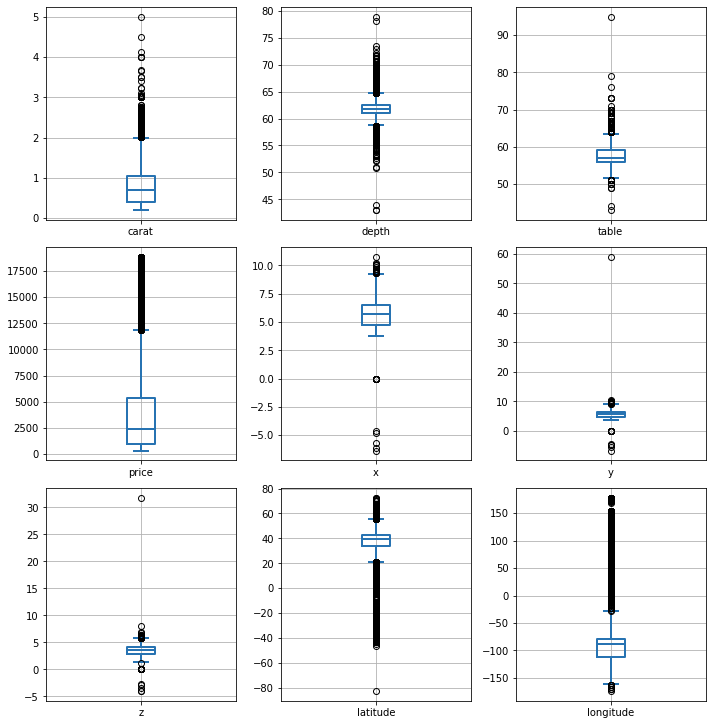

In [35]:
_plt_boxplot(df, numerical_features)

## Outliers

Both histograms and boxplots show that there are some outliers. Let's delete some of them with tukey rule:

In [36]:
def _label_outliers(df: pd.DataFrame,
                    numerical_features: List[str]
                   ) -> pd.DataFrame:
    """
    Perform tukey method for outliers in every numerical_feature
    """
    for feature in numerical_features:
        df_outliers = _label_outliers_tukey(df, feature, f'outlier_{feature}')
    return df_outliers

def _label_outliers_tukey(df: pd.DataFrame,
                          column: str,
                          outlier_column: str
                         ) -> pd.DataFrame:
    """
    Perform tukey method to identify outliers
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    df[outlier_column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), True, False)
    return df

In [37]:
df_out = _label_outliers(df, numerical_features)

In [38]:
_query = "outlier_carat == False and outlier_price == False and outlier_depth == False and outlier_table == False and outlier_x == False and outlier_y == False and outlier_z == False"

df_no_outliers = df_out.query(_query)

per_data_with_no_outlier = (df_no_outliers.shape[0])/(df.shape[0])
per_data_with_no_outlier

0.8828459641380333

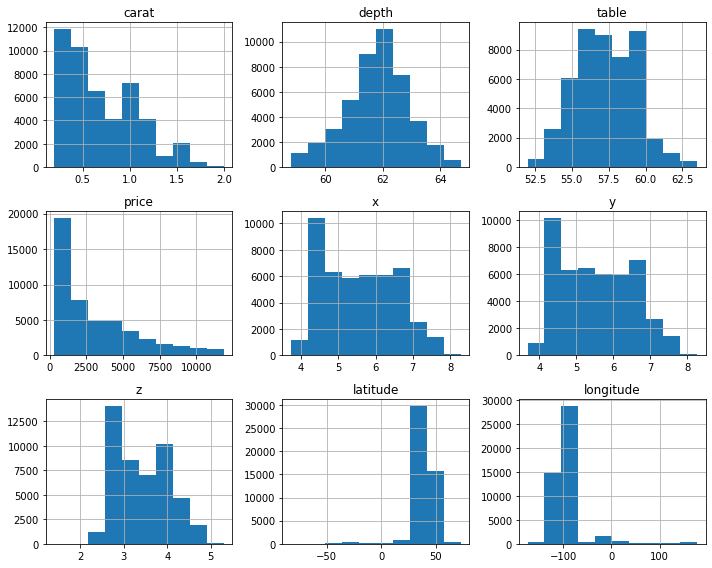

In [39]:
_plt_histogram(df_no_outliers, numerical_features)

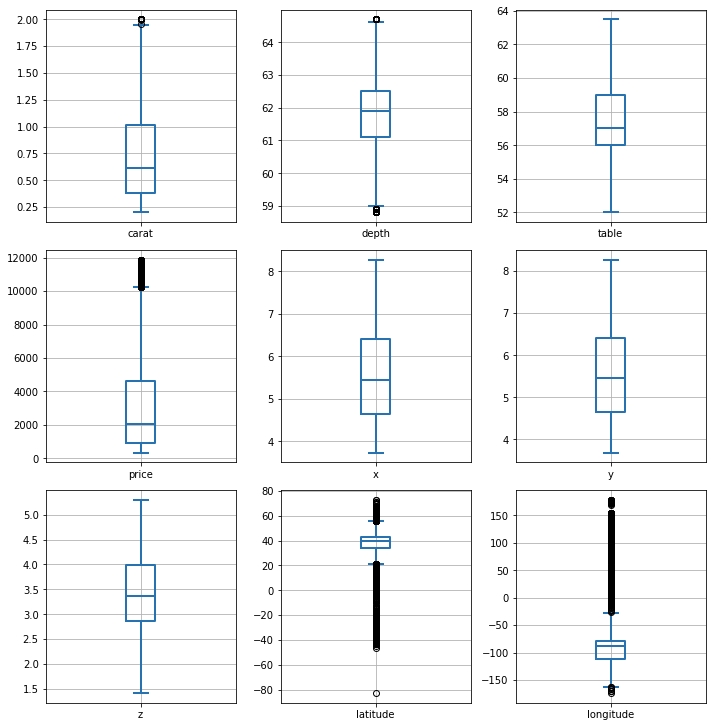

In [40]:
_plt_boxplot(df_no_outliers, numerical_features)

In [41]:
df = df_no_outliers[numerical_features + categorical_features]

Even when 12% of data is lost, the distributions have less bias, which is great for built models

## Correlation

Scatter plot:

In [42]:
corr_matrix = df[numerical_features].corr()
corr_matrix

,carat,depth,table,price,x,y,z,latitude,longitude
carat,1.000000,0.035497,0.187554,0.922608,0.986239,0.985385,0.984879,-0.002727,0.005006
depth,0.035497,1.000000,-0.239933,0.005761,-0.011007,-0.012764,0.092158,-0.001036,-0.001699
table,0.187554,-0.239933,1.000000,0.136779,0.187094,0.181224,0.159105,0.000561,0.005028
price,0.922608,0.005761,0.136779,1.000000,0.899739,0.900735,0.896064,-0.002246,0.005298
x,0.986239,-0.011007,0.187094,0.899739,1.000000,0.998526,0.993216,-0.002733,0.003895
y,0.985385,-0.012764,0.181224,0.900735,0.998526,1.000000,0.992978,-0.002381,0.004170
z,0.984879,0.092158,0.159105,0.896064,0.993216,0.992978,1.000000,-0.001553,0.004146
latitude,-0.002727,-0.001036,0.000561,-0.002246,-0.002733,-0.002381,-0.001553,1.000000,-0.377155
longitude,0.005006,-0.001699,0.005028,0.005298,0.003895,0.004170,0.004146,-0.377155,1.000000


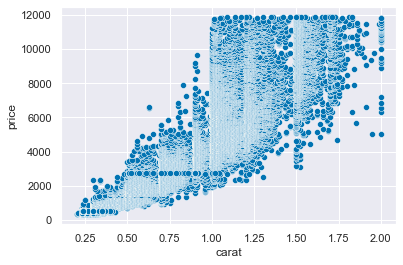

In [43]:
sns.set(style='darkgrid', palette='colorblind')
sns.scatterplot(x='carat', y='price', data=df)
plt.show()

- carat is the feature that has the higher linear positive correlation with target (price)
- the features: x, y, z, have a high linear correlation with target but also with carat, so multicollinearity exists
- the features: depth, table, latitude, longitude, have a low linear correlation with target

Taking into account the above, it is decided to work only with "carat" as numerical feature to create models

## Categorical analysis

In [44]:
def _sns_grouped_boxplot(df: pd.DataFrame,
                         numerical_feature: str,
                         group_feature: str
                        ):
    """
    Plot grouped boxplot
    """
    my_plot = sns.boxplot(x=group_feature,
                          y=numerical_feature,
                          data=df,
                          palette="Blues",
                          hue=group_feature,
                          legend=False                      
                         )
    plt.xticks(fontsize=9)

    plt.tight_layout()
    plt.show()

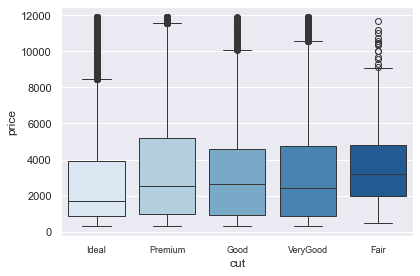

In [45]:
_sns_grouped_boxplot(df, 'price', 'cut')

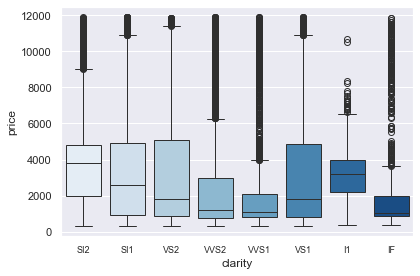

In [46]:
_sns_grouped_boxplot(df, 'price', 'clarity')

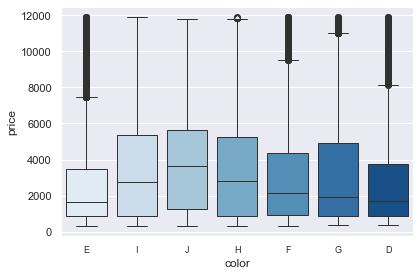

In [47]:
_sns_grouped_boxplot(df, 'price', 'color')

Categorical features seem to have no influence in target variable

# Built Models

## Train, Test split

In [48]:
X = df.drop(["price"], axis=1)
y = df[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

## Transform features

In [49]:
def _transform_features(X_train: pd.DataFrame,
                        X_test: pd.DataFrame,
                        y_train: pd.DataFrame,
                        y_test: pd.DataFrame,
                        numerical_features: List[str],
                        categorical_features: List[str]
                       ):
    """
    Apply transformations to train and test sets
    """
    categorical_transformer = Pipeline(
        steps=[("one_hot", OneHotEncoder(drop ="first"))]
    )

    preprocessor = ColumnTransformer(
        transformers=[('num', 'passthrough', numerical_features),
                      ("cat", categorical_transformer, categorical_features)]
    )

    clf_t = Pipeline(
        steps=[("preprocessor", preprocessor)]
    )
    
    # transformer
    clf_t.fit(X_train)
    
    # train
    mat_train = clf_t.transform(X_train).toarray()
    X_train_t = pd.DataFrame(mat_train, columns = clf_t.get_feature_names_out(), index=X_train.index)

    # test
    mat_test = clf_t.transform(X_test).toarray()
    X_test_t = pd.DataFrame(mat_test, columns = clf_t.get_feature_names_out(), index=X_test.index)
    
    return X_train_t, X_test_t, y_train, y_test, clf_t

In [50]:
numerical_features = ['carat']
categorical_features = ['cut', "clarity", 'color']
X_train_t, X_test_t, y_train, y_test, clf_t = _transform_features(X_train, X_test, y_train, y_test, numerical_features, categorical_features)

## Linear regression

In [51]:
mod = OLS(y_train, X_train_t)
res_lr = mod.fit()
print(res_lr.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                          4.590e+04
Date:                Fri, 12 Jan 2024   Prob (F-statistic):                        0.00
Time:                        16:35:50   Log-Likelihood:                     -2.9117e+05
No. Observations:               35708   AIC:                                  5.824e+05
Df Residuals:                   35690   BIC:                                  5.825e+05
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

## Lasso 

In [52]:
mod = OLS(y_train, X_train_t)
res_l1 = mod.fit_regularized(alpha=3, L1_wt=1, refit=True)
print(res_l1.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.957
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                          5.666e+04
Date:                Fri, 12 Jan 2024   Prob (F-statistic):                        0.00
Time:                        16:35:55   Log-Likelihood:                     -2.9187e+05
No. Observations:               35708   AIC:                                  5.838e+05
Df Residuals:                   35694   BIC:                                  5.839e+05
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

## Quantile regression

In [53]:
mod = QuantReg(y_train, X_train_t)
res_qr = mod.fit(q=0.3, max_iter=10000)
print(res_qr.summary())

                         QuantReg Regression Results                          
Dep. Variable:                  price   Pseudo R-squared:               0.7067
Model:                       QuantReg   Bandwidth:                       56.35
Method:                 Least Squares   Sparsity:                        913.6
Date:                Fri, 12 Jan 2024   No. Observations:                35708
Time:                        16:36:02   Df Residuals:                    35690
                                        Df Model:                           18
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
num__carat         6403.0303      5.512   1161.644      0.000    6392.227    6413.834
cat__cut_Good     -2939.6061     27.068   -108.602      0.000   -2992.659   -2886.553
cat__cut_Ideal    -2808.7576     26.232   -107.075      0.000   -2860.172   -2757.343
cat__cut_Premium 

## Gradient Boosting Regressor

In [54]:
# GradientBoostingRegressor
mod = GradientBoostingRegressor()
res_gb = mod.fit(X_train_t, y_train.iloc[:, 0])

## Metrics

In [55]:
def _evaluate_model(X_train: pd.DataFrame,
                    X_test: pd.DataFrame,
                    y_train: pd.DataFrame,
                    y_test: pd.DataFrame,
                    model
                   ):
    """
    Get several metrics for regression model in train and test sets
    """
    
    metrics_train = _get_metrics(y_train, X_train, model)
    metrics_test = _get_metrics(y_test, X_test, model)
    
    print("metrics_train")    
    print(metrics_train)
    print("metrics_test")    
    print(metrics_test)
    
    return metrics_train, metrics_test

def _get_metrics(y_true: pd.DataFrame,
                 X: pd.DataFrame,
                 model
                ):
    """
    Get several metrics for regression model
    """
    y_pred = model.predict(X)
    
    r2_score_ = r2_score(y_true, y_pred)
    r2_score_adjust_ = r2_score_adjust(y_true, X, model)
    mse_ = mean_squared_error(y_true, y_pred)
    mae_ = mean_absolute_error(y_true, y_pred)
    mape_ = mean_absolute_percentage_error(y_true, y_pred)
    mdape_ = median_absolute_percentage_error(y_true, y_pred)
    
    metrics = {'MSE': mse_,
               'MAE': mae_,
               'MAPE': mape_,
               'MDAPE': mdape_,
               'R2': r2_score_,
               'R2_adjust': r2_score_adjust_
              }
    return metrics

def r2_score_adjust(y_true: pd.DataFrame,
                    X: pd.DataFrame,
                    model
                   ):
    """
    Calculate R2 adjust
    """
    n = X.shape[0]
    p = X.shape[1]
    y_pred = model.predict(X)
    r2_score_ = r2_score(y_true, y_pred)    
    return 1-(1-r2_score_)*(n-1)/(n-p-1)

def median_absolute_percentage_error(y_true: pd.DataFrame,
                                     y_pred
                                    ):
    """
    Calculate Median Absolute Percentage Error (MdAPE)
    """
    return np.median(np.abs((y_true.iloc[:, 0] - y_pred)/y_true.iloc[:, 0]))

### Linear regression metrics

In [56]:
metrics_lr = _evaluate_model(X_train_t, X_test_t, y_train, y_test, res_lr)

metrics_train
{'MSE': 708300.7148546939, 'MAE': 577.0385902687775, 'MAPE': 0.3374994632230919, 'MDAPE': 0.1968971442094661, 'R2': 0.9057643024382095, 'R2_adjust': 0.9057167739965016}
metrics_test
{'MSE': 745744.2962577849, 'MAE': 583.621418043232, 'MAPE': 0.3280674970695717, 'MDAPE': 0.19596519712984772, 'R2': 0.903005118005073, 'R2_adjust': 0.9028582055281369}


### Lasso metrics

In [57]:
metrics_l1 = _evaluate_model(X_train_t, X_test_t, y_train, y_test, res_l1)

metrics_train
{'MSE': 736576.2186145514, 'MAE': 580.9753952316855, 'MAPE': 0.33476798149899595, 'MDAPE': 0.1918785693429622, 'R2': 0.9020023948686713, 'R2_adjust': 0.9019529690822283}
metrics_test
{'MSE': 772165.2166682428, 'MAE': 586.0750177701091, 'MAPE': 0.325820502714163, 'MDAPE': 0.19035314586133073, 'R2': 0.899568693388392, 'R2_adjust': 0.8994165759600001}


### Quantile regression metrics

In [58]:
metrics_qr = _evaluate_model(X_train_t, X_test_t, y_train, y_test, res_qr)

metrics_train
{'MSE': 1083149.1597688873, 'MAE': 584.9051300262654, 'MAPE': 0.2616080888802138, 'MDAPE': 0.13847149580383486, 'R2': 0.8558926816059644, 'R2_adjust': 0.8558200000589585}
metrics_test
{'MSE': 1148213.5754251292, 'MAE': 601.1071702040938, 'MAPE': 0.2548473003574396, 'MDAPE': 0.13643203889031408, 'R2': 0.8506581400458535, 'R2_adjust': 0.8504319406618772}


### Gradient boosting regressor metrics

In [59]:
metrics_gb = _evaluate_model(X_train_t, X_test_t, y_train, y_test, res_gb)

metrics_train
{'MSE': 321428.1600022846, 'MAE': 310.51245721745073, 'MAPE': 0.1202445241933882, 'MDAPE': 0.08410768930894033, 'R2': 0.9572356680735075, 'R2_adjust': 0.9572140995797229}
metrics_test
{'MSE': 342958.2797545718, 'MAE': 319.82773740347403, 'MAPE': 0.12058522017069294, 'MDAPE': 0.08489530712192377, 'R2': 0.9553932922572713, 'R2_adjust': 0.9553257290849919}


## Models Conclusion

- Since the metrics for train and test are similar, there are no overfitting problems
- Gradient boosting regressor has better metrics than other algorithms, that's why we recommend to use this model to do predictions

# Geostatistical analysis

In [60]:
def _gdf_plot(df: pd.DataFrame,
              longitude_feature: str,
              latitude_feature: str
             ):
    """
    Plot geographical points by longitude and latitude
    """
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[longitude_feature], df[latitude_feature]))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot()
    gdf.plot(ax=plt.gca(), marker='o', markersize=10, color='red')
    plt.show()

<ipython-input-60-27139277d512>:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


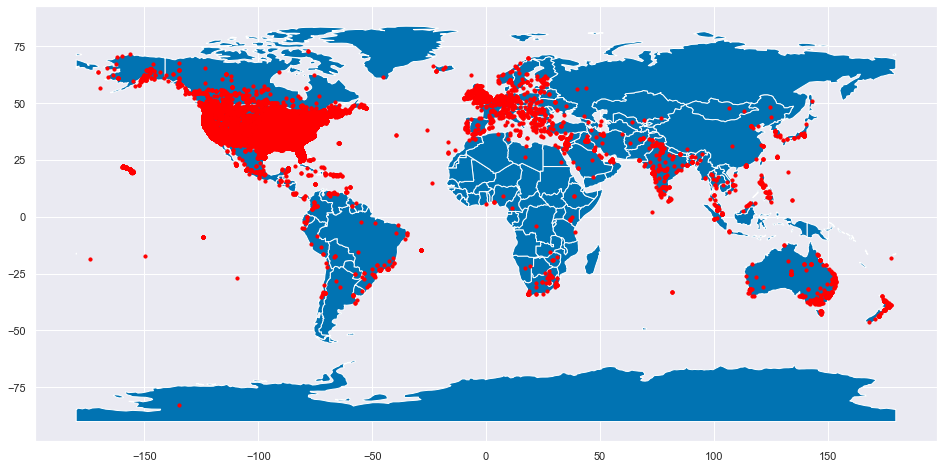

In [63]:
plt.rcParams["figure.figsize"] = (30, 8)
_gdf_plot(df, 'longitude', 'latitude')

It seems like there are several places to take advantage of diamonds market